## Загрузим нужные библиотеки и файлы

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn import tree
import numpy as np
from sklearn.metrics import f1_score
from google.colab.data_table import DataTable
DataTable.max_columns = 80
%matplotlib inline

In [2]:
from google.colab import files


uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving sample_submission1.csv to sample_submission1.csv
Saving test_dataset_test (1).csv to test_dataset_test (1).csv
Saving train_dataset_train.csv to train_dataset_train.csv
User uploaded file "sample_submission1.csv" with length 46893 bytes
User uploaded file "test_dataset_test (1).csv" with length 2050262 bytes
User uploaded file "train_dataset_train.csv" with length 4186716 bytes


In [46]:
df = pd.read_csv('train_dataset_train.csv')

## Рассмотрим датасет поближе

In [47]:
df.head(5)

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08 00:00:00.000,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,...,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18 00:00:00.000,NaN,NaN,NaN,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21 00:00:00.000,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4
3,81661,19838,2017,Жен,БН,Английский язык,1994-12-08 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4
4,81509,19803,2017,Жен,БН,Английский язык,1995-06-28 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4


In [48]:
df.shape

(13584, 24)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                13584 non-null  int64  
 1   Код_группы        13584 non-null  int64  
 2   Год_Поступления   13584 non-null  int64  
 3   Пол               13577 non-null  object 
 4   Основания         13584 non-null  object 
 5   Изучаемый_Язык    12758 non-null  object 
 6   Дата_Рождения     13584 non-null  object 
 7   Уч_Заведение      12351 non-null  object 
 8   Где_Находится_УЗ  12203 non-null  object 
 9   Год_Окончания_УЗ  12284 non-null  float64
 10  Пособие           12576 non-null  float64
 11  Страна_ПП         13237 non-null  object 
 12  Регион_ПП         12966 non-null  object 
 13  Город_ПП          13141 non-null  object 
 14  Общежитие         13498 non-null  float64
 15  Наличие_Матери    13584 non-null  int64  
 16  Наличие_Отца      13584 non-null  float6

In [50]:
df.duplicated().sum()

0

Заменим все пропуски в данных

In [51]:
df = df.fillna(0)

Пострим распределения данных

Text(0.5, 1.0, 'Распределение предсказываемой величены')

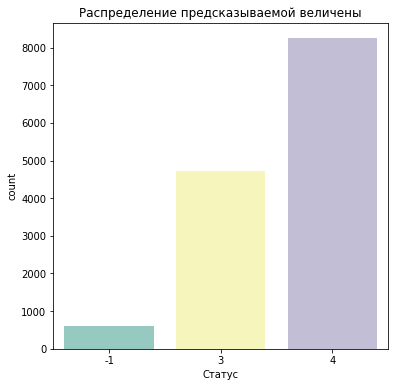

In [52]:
plt.figure(figsize=(6,6))
sns.countplot(x = "Статус" , data  = df, palette = "Set3").set_title('Распределение предсказываемой величены')

Text(0.5, 1.0, 'Распределение года поступления')

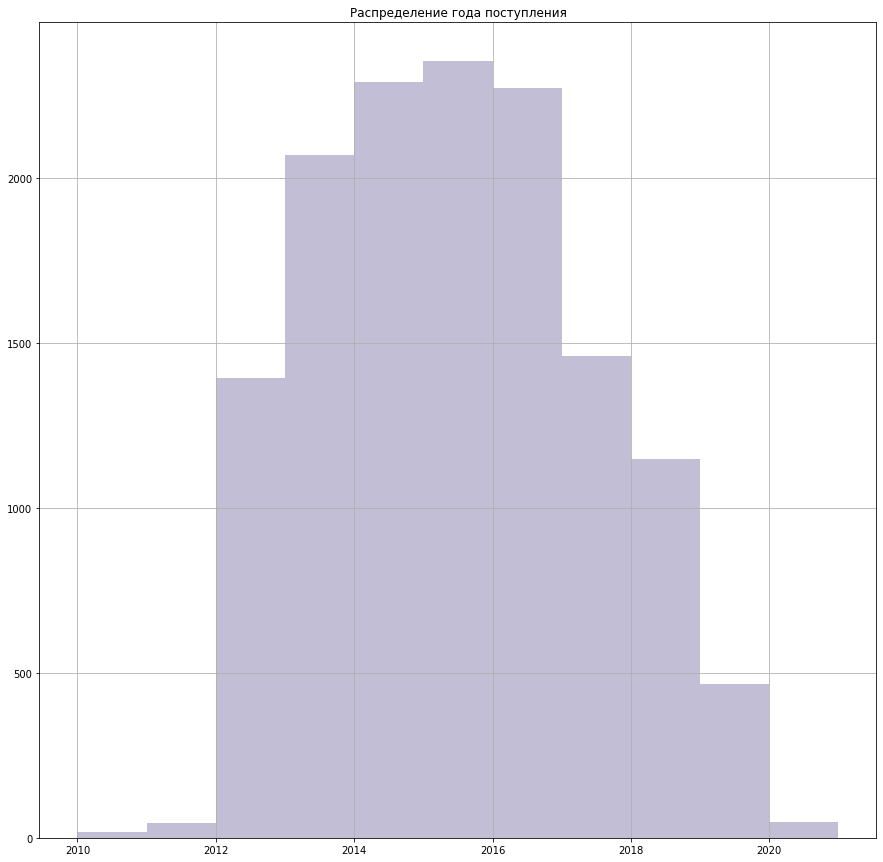

In [53]:
df["Год_Поступления"].hist(bins = 11, range = [2010, 2021], color='#C1BED6').set_title('Распределение года поступления')

Взглянем на несколько величин сразу

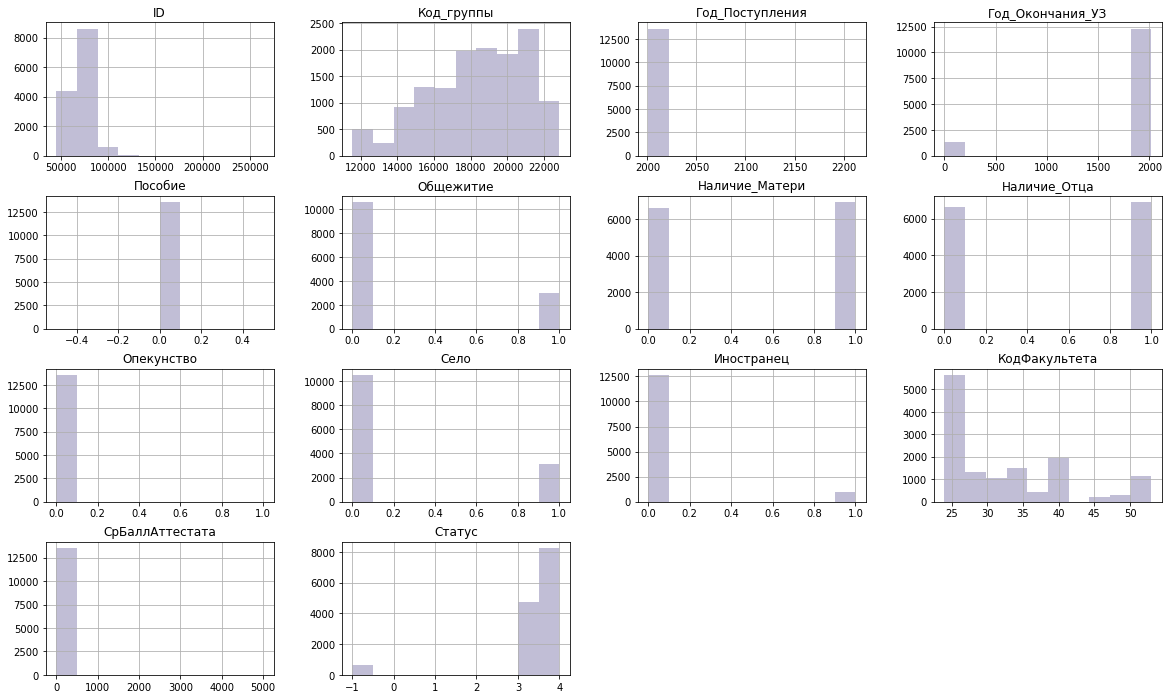

In [54]:
_ = df[df.columns].hist(figsize=(20,12), color='#C1BED6')

Обратим внимание на часть столбцов с постоянными значениями

In [55]:
df["Пособие"].value_counts()

0.0    13584
Name: Пособие, dtype: int64

In [56]:
#df["Пособие"].value_counts()

In [57]:
df["Опекунство"].value_counts()

0.0    13578
1.0        6
Name: Опекунство, dtype: int64

Зададим примерный возраст поступившего

In [58]:
df['Дата_Рождения'] = pd.to_datetime(df['Дата_Рождения'])
df['Год_Рождения'] = df['Дата_Рождения'].dt.year
df['возраст_пост'] = df['Год_Поступления'] - df['Год_Рождения']

In [59]:
df.columns.values

array(['ID', 'Код_группы', 'Год_Поступления', 'Пол', 'Основания',
       'Изучаемый_Язык', 'Дата_Рождения', 'Уч_Заведение',
       'Где_Находится_УЗ', 'Год_Окончания_УЗ', 'Пособие', 'Страна_ПП',
       'Регион_ПП', 'Город_ПП', 'Общежитие', 'Наличие_Матери',
       'Наличие_Отца', 'Страна_Родители', 'Опекунство', 'Село',
       'Иностранец', 'КодФакультета', 'СрБаллАттестата', 'Статус',
       'Год_Рождения', 'возраст_пост'], dtype=object)

Построим тепловую карту корреляций, удалив неинформативные столбцы

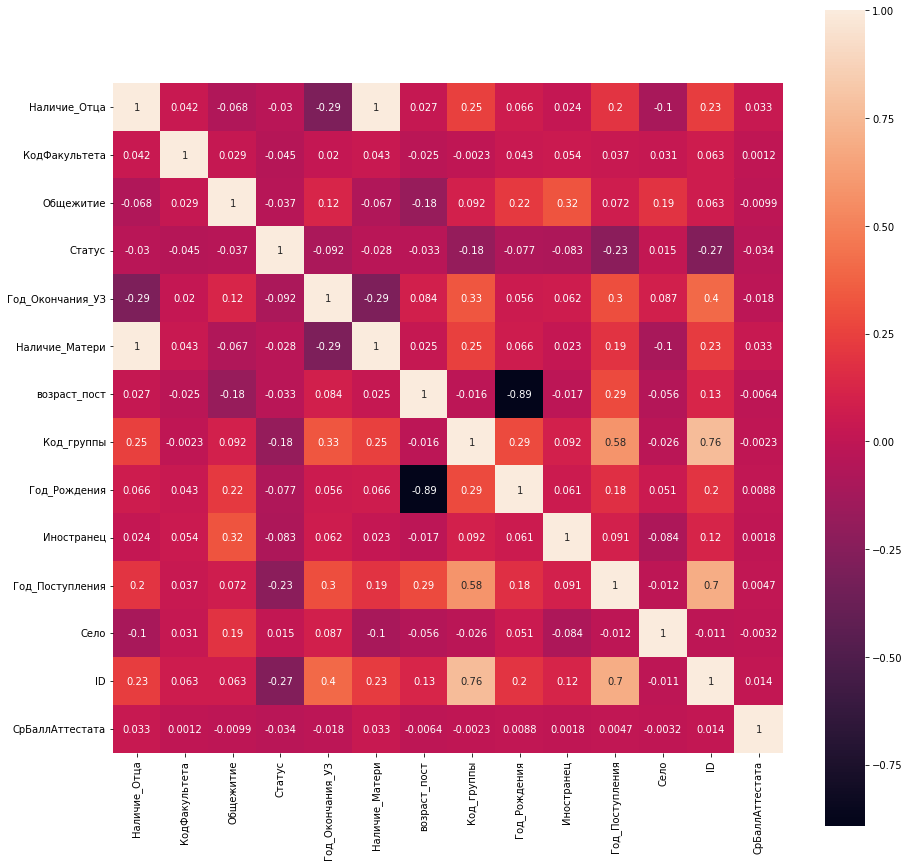

In [60]:
plt.rcParams['figure.figsize']=(15,15)

df_corr = list(set(df.columns.values) - set(['Опекунство','Пособие']))
g = sns.heatmap(df[df_corr].corr(), square = True, annot=True)

## Работа над текстовыми переменными

In [61]:
df.dtypes[df.dtypes == "object"].index.values

array(['Пол', 'Основания', 'Изучаемый_Язык', 'Уч_Заведение',
       'Где_Находится_УЗ', 'Страна_ПП', 'Регион_ПП', 'Город_ПП',
       'Страна_Родители'], dtype=object)

Найдем русских и иностранцев по ПП

In [62]:
df['Страна_ПП'] = df['Страна_ПП'].apply(lambda x: 'Россия' if x=='Россия' else 'зарубеж')

Избавимся от некорректного пола

In [63]:
df["Пол"].value_counts()

Жен    8133
Муж    5443
0         7
муж       1
Name: Пол, dtype: int64

In [64]:
#df = df.query('Пол in ("Муж","Жен")').reset_index(drop=True)
df["Пол"] = df["Пол"].replace( {'муж':'Муж',
                                 0 :'Муж',
                                'жен' : 'Жен'}
                             )    

Почистим категории в Языках

In [65]:
df["Изучаемый_Язык"].value_counts()

Английский язык                  10450
Немецкий язык                     2219
0                                  826
Французский язык                    54
Русский язык                        11
Иностранный язык (Английский)       10
Англиийский                         10
Иностранный язык (Немецкий)          4
Name: Изучаемый_Язык, dtype: int64

In [66]:
df["Изучаемый_Язык"] = df["Изучаемый_Язык"].replace( {'Иностранный язык (Английский)':'Английский язык',
                               'Англиийский' :'Английский язык',
                               'Иностранный язык (Немецкий)' : 'Немецкий язык'}
                             )                               

In [67]:
df["Основания"].value_counts()

ОО    5084
СН    4558
БН    1882
ДН    1853
ЦН     207
Name: Основания, dtype: int64

Преобразуем категориальные поля в множество бинарных полей (One-hot Encoding)

In [68]:
df = pd.get_dummies(df, columns=["Пол", "Изучаемый_Язык","Основания","Страна_ПП"], prefix=["Пол", "Язык","ОСН","страна"])

In [69]:
df.head()

,ID,Код_группы,Год_Поступления,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,Регион_ПП,Город_ПП,...,Язык_Немецкий язык,Язык_Русский язык,Язык_Французский язык,ОСН_БН,ОСН_ДН,ОСН_ОО,ОСН_СН,ОСН_ЦН,страна_Россия,страна_зарубеж
0,72716,16019,2015,1998-02-08,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,0.0,Алтайский край,Барнаул г,...,0,0,0,0,0,1,0,0,1,0
1,63306,14895,2010,1992-04-18,0,0,0.0,0.0,Алтайский край,Барнаул г,...,0,0,0,0,0,0,0,1,1,0
2,82469,20103,2017,1999-03-21,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,0.0,Алтайский край,Алтайское с,...,0,0,0,0,1,0,0,0,1,0
3,81661,19838,2017,1994-12-08,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,0.0,Алтайский край,г. Барнаул,...,0,0,0,1,0,0,0,0,1,0
4,81509,19803,2017,1995-06-28,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,0.0,Алтайский край,г. Барнаул,...,0,0,0,1,0,0,0,0,1,0


Поместим все столбцы object в массив, для их дальнейшего удаления

In [70]:
mass_object = ('Дата_Рождения',
       'Уч_Заведение', 'Где_Находится_УЗ',  'Регион_ПП',
       'Город_ПП', 'Страна_Родители')
mass_object = np.append(mass_object, "Статус")

In [71]:
mass_object

array(['Дата_Рождения', 'Уч_Заведение', 'Где_Находится_УЗ', 'Регион_ПП',
       'Город_ПП', 'Страна_Родители', 'Статус'], dtype='<U16')

## Получение выборки для трейна и теста

In [72]:
X = df.drop(mass_object, axis = 1)
y = df[["Статус"]]

In [73]:
X.head()

,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Пособие,Общежитие,Наличие_Матери,Наличие_Отца,Опекунство,Село,...,Язык_Немецкий язык,Язык_Русский язык,Язык_Французский язык,ОСН_БН,ОСН_ДН,ОСН_ОО,ОСН_СН,ОСН_ЦН,страна_Россия,страна_зарубеж
0,72716,16019,2015,2014.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
1,63306,14895,2010,0.0,0.0,0.0,1,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0
2,82469,20103,2017,2017.0,0.0,0.0,1,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,81661,19838,2017,2017.0,0.0,0.0,1,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4,81509,19803,2017,2017.0,0.0,0.0,1,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0


Разделим выборку на обучающий и тестовый датасеты

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5)

Обучим модель тремя способами: **RandomForestClassifier, GradientBoostingClassifier и XGBClassifier** и проанализируем предварительный результат

In [75]:
models = []
models.append(('RandomForest',RandomForestClassifier(n_estimators=100,random_state=5)))
models.append(('GradientBoosting',GradientBoostingClassifier(n_estimators=100, max_features=5, max_depth=2, random_state=5)))
models.append(('XGBClassifier',XGBClassifier(max_depth = 5,  n_estimators = 100)))

for name, model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test) 
  print('================',name,'================')
  print(classification_report(y_test, y_pred))
  print(model.score(X_test,y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


================ RandomForest ================
              precision    recall  f1-score   support

          -1       0.54      0.30      0.39        86
           3       0.86      0.80      0.83       704
           4       0.90      0.96      0.93      1248

    accuracy                           0.88      2038
   macro avg       0.77      0.69      0.71      2038
weighted avg       0.87      0.88      0.87      2038

0.8778213935230619


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


================ GradientBoosting ================
              precision    recall  f1-score   support

          -1       0.59      0.38      0.46        86
           3       0.88      0.67      0.76       704
           4       0.84      0.98      0.90      1248

    accuracy                           0.84      2038
   macro avg       0.77      0.68      0.71      2038
weighted avg       0.84      0.84      0.84      2038

0.844946025515211


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


================ XGBClassifier ================
              precision    recall  f1-score   support

          -1       0.62      0.40      0.48        86
           3       0.90      0.80      0.85       704
           4       0.90      0.98      0.94      1248

    accuracy                           0.89      2038
   macro avg       0.81      0.73      0.76      2038
weighted avg       0.89      0.89      0.89      2038

0.8935230618253189


Моделирование с помощью XGBoost показало себя лучше всего. Выберем его в качестве основного, оптимизируем гиперпараметры.

In [76]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(max_depth = 5,  n_estimators = 600, eta = 0.01)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test) 
score = xgb_clf.score(X_test, y_test)
print(classification_report(y_test, y_pred))
print(xgb_clf.score(X_test,y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

          -1       0.62      0.47      0.53        86
           3       0.90      0.83      0.86       704
           4       0.92      0.98      0.95      1248

    accuracy                           0.90      2038
   macro avg       0.81      0.76      0.78      2038
weighted avg       0.90      0.90      0.90      2038

0.9028459273797841


In [77]:
y_test.head(3)

,Статус
11556,4
2623,4
3392,4


# Cоздание файла с ответом на тестовой выборке

In [78]:
df_test = pd.read_csv("test_dataset_test (1).csv")
df_submission = pd.read_csv("sample_submission1.csv")

In [79]:
df_submission.head(3)

,ID,Статус
0,64996,NaN
1,71837,NaN
2,86587,NaN


Провем те же манипуляции с данными что и на обучении

In [80]:
df_test['Дата_Рождения'] = pd.to_datetime(df_test['Дата_Рождения'])
df_test['Год_Рождения'] = df_test['Дата_Рождения'].dt.year
df_test['возраст_пост'] = df_test['Год_Поступления'] - df_test['Год_Рождения']

In [81]:
#mass_object1 = df.dtypes[df.dtypes == "object"].index.values
mass_object = np.array(['Дата_Рождения',
       'Уч_Заведение', 'Где_Находится_УЗ',  'Регион_ПП',
       'Город_ПП', 'Страна_Родители'])
mass_object
df_test = df_test.drop(mass_object, axis = 1)

In [82]:
df_test = df_test.fillna(0)
df_test.head()

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Год_Окончания_УЗ,Пособие,Страна_ПП,Общежитие,Наличие_Матери,Наличие_Отца,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Год_Рождения,возраст_пост
0,64996,20608,2014,Жен,ДН,Английский язык,2014.0,0.0,Россия,0.0,0,0.0,0.0,0.0,0.0,40.0,49.0,1995,19
1,71837,20613,2015,Жен,ДН,Немецкий язык,2014.0,0.0,Россия,0.0,0,0.0,0.0,1.0,0.0,26.0,77.0,1995,20
2,86587,21210,2018,Жен,ОО,Английский язык,1997.0,0.0,Россия,0.0,1,1.0,0.0,0.0,0.0,34.0,74.0,1973,45
3,73673,22254,2015,Жен,ОО,Английский язык,2006.0,0.0,Россия,0.0,0,0.0,0.0,0.0,0.0,53.0,57.0,1983,32
4,54709,15040,2012,Жен,ОО,0,0.0,0.0,0,0.0,1,1.0,0.0,0.0,0.0,36.0,55.0,1994,18


In [83]:
df_test["Пол"] = df_test["Пол"].replace( {'муж':'Муж',
                                 0 :'Муж',
                                'жен' : 'Жен'}
                             ) 
df_test["Изучаемый_Язык"] = df_test["Изучаемый_Язык"].replace( {'Иностранный язык (Английский)':'Английский язык',
                               'Англиийский' :'Английский язык',
                               'Иностранный язык (Немецкий)' : 'Немецкий язык',
                               'Английский, немецкий языки' : 'Английский язык'}
                             ) 
df_test["Основания"] = df_test["Основания"].replace( {'ЛН':'СН'} )   
df_test['Страна_ПП'] = df_test['Страна_ПП'].apply(lambda x: 'Россия' if x=='Россия' else 'зарубеж')

df_test = pd.get_dummies(df_test, columns=["Пол", "Изучаемый_Язык","Основания","Страна_ПП"], prefix=["Пол", "Язык","ОСН","страна"])
df_test.head()

,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Пособие,Общежитие,Наличие_Матери,Наличие_Отца,Опекунство,Село,...,Язык_Немецкий язык,Язык_Русский язык,Язык_Французский язык,ОСН_БН,ОСН_ДН,ОСН_ОО,ОСН_СН,ОСН_ЦН,страна_Россия,страна_зарубеж
0,64996,20608,2014,2014.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,71837,20613,2015,2014.0,0.0,0.0,0,0.0,0.0,1.0,...,1,0,0,0,1,0,0,0,1,0
2,86587,21210,2018,1997.0,0.0,0.0,1,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
3,73673,22254,2015,2006.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
4,54709,15040,2012,0.0,0.0,0.0,1,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1


In [84]:
df_test_pred = xgb_clf.predict(df_test)

In [85]:
df_submission["Статус"] = df_test_pred
df_submission.head(4)

,ID,Статус
0,64996,4
1,71837,4
2,86587,4
3,73673,-1


In [86]:
df_submission.to_csv('submission.csv', index = False)
from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>